Typically, the standard linear model $Y=\beta_0+\beta_1X_1+...+\beta_pX_p+\epsilon$ is fitted using the least squares method. However, there are alternative fitting procedures that can yield better prediction accuracy and model interpretability.

* **Prediction Accuracy:** If the true relationship between the response and the predictor is approximately linear, the least square estimates will have low bias. If the number of predictors ($p$) is much less than the number of observations ($n$) then the least square estimates tend to also have low variance, and will perform well on test observations. However, if $n$ is not much larger than p, then there can be a lot of variability in the least square fit.
* **Model Interpretability:** Many of the variables used in a multiple regression model may not be associated with the response. By removing these variables we can obtain a model that is easily interpreted. 

### Subset Selection  
Subset selection involves identifying a subset of $p$ predictors that we believe to be related to the response. When fit a model using the reduced subset.

In [75]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, precision_score

import statsmodels.api as sm

from itertools import combinations,chain

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline

#### Best Subset Selection
To perform best subset selection, we perform a seperate least square regression for each possible combination of $p$ predictors, resulting in $2^p$ possible models, with the goal of identifying the one that is best.
This is usually broken up int three stages.
1. Let $M_0$ denote the null model, which contains no predictors. This model simple predicts the sample mean for each observation.
2. For $k=1,2,..p$:  
a. Fit all $(^p_k)$ models that contain exactly k predcitors.  
b. Pick best amoung these models, and call it $M_k$. Here the best is defined as having the smallest RSS, or equivalently largest $R^2$
3. Select a single best model from among $M_0,...,M_p$ using cross validation prediction error, $C_p (AIC), BIC$ or adjusted $R^2$

#### Performing Best Subset Selection for Credit data set

In [3]:
credit = pd.read_csv('./Credit.csv')
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
Unnamed: 0    400 non-null int64
Income        400 non-null float64
Limit         400 non-null int64
Rating        400 non-null int64
Cards         400 non-null int64
Age           400 non-null int64
Education     400 non-null int64
Gender        400 non-null object
Student       400 non-null object
Married       400 non-null object
Ethnicity     400 non-null object
Balance       400 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 31.3+ KB


In [4]:
credit.drop('Unnamed: 0',axis=1,inplace=True)
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [5]:
# Creating dummy variables for categorical data. For variables with two levels we can use pd.factorize()
credit['d_Gender']=pd.factorize(credit['Gender'])[0]
print ('d_Gender factors',pd.factorize(credit['Gender'])[1])

credit['d_Student']=pd.factorize(credit['Student'])[0]
print ('d_Gender factors',pd.factorize(credit['Student'])[1])

credit['d_Married']=pd.factorize(credit['Married'])[0]
print ('d_Gender factors',pd.factorize(credit['Married'])[1])

credit = pd.concat([credit,pd.get_dummies(credit['Ethnicity'],prefix='D')],axis=1)

d_Gender factors Index([' Male', 'Female'], dtype='object')
d_Gender factors Index(['No', 'Yes'], dtype='object')
d_Gender factors Index(['Yes', 'No'], dtype='object')


In [6]:
credit.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender',
       'Student', 'Married', 'Ethnicity', 'Balance', 'd_Gender', 'd_Student',
       'd_Married', 'D_African American', 'D_Asian', 'D_Caucasian'],
      dtype='object')

In [7]:
## Remove categorical columns 
credit.drop(['Gender','Student','Married','Ethnicity','D_Caucasian'],inplace = True, axis=1)

features = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender',
            'd_Student', 'd_Married', 'D_African American', 'D_Asian']
target = 'Balance'

In [8]:
# For each of the models record the test score
def create_models(df, features, target, scoring = 'RSS'):
    models = []
    for model_size in range(1,len(features)+1):
    # Create subsets with n features each
        for i,subset in enumerate(combinations(features,model_size)):
            X = df[list(subset)]
            y = df[target]
        # Calcuate CV score for each subset
            model = sm.OLS(y, sm.add_constant(df[list(subset)])).fit()
        # Store the subset score and the number of predictors used
            models.append({'Model Size': model_size, 'Model':model, 'Subset':subset})
    
    return pd.DataFrame(models)

In [31]:
## Create dataframe with all possible subset models
subset_models = create_models(credit, features, target)

In [10]:
subset_models.head()

,Model,Model Size,Subset
0,<statsmodels.regression.linear_model.Regressio...,1,"(Income,)"
1,<statsmodels.regression.linear_model.Regressio...,1,"(Limit,)"
2,<statsmodels.regression.linear_model.Regressio...,1,"(Rating,)"
3,<statsmodels.regression.linear_model.Regressio...,1,"(Cards,)"
4,<statsmodels.regression.linear_model.Regressio...,1,"(Age,)"


In [32]:
# For each model calculate the RSS and add to the DataFrame
subset_models['RSS'] = subset_models.apply(lambda row: sum(row[0].resid**2),axis =1)
subset_models['R2'] = subset_models.apply(lambda row: row[0].rsquared,axis =1)

In [33]:
## We can view all models for a given model size using the following method
subset_models[subset_models['Model Size']==10]

,Model,Model Size,Subset,RSS,R2
2035,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Limit, Rating, Cards, Age, Education,...",3.789709e+06,0.955066
2036,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Limit, Rating, Cards, Age, Education,...",3.793418e+06,0.955022
2037,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Limit, Rating, Cards, Age, Education,...",3.793349e+06,0.955023
2038,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Limit, Rating, Cards, Age, Education,...",1.011274e+07,0.880095
2039,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Limit, Rating, Cards, Age, Education,...",3.798000e+06,0.954968
2040,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Limit, Rating, Cards, Age, d_Gender, ...",3.791345e+06,0.955047
2041,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Limit, Rating, Cards, Education, d_Ge...",3.829288e+06,0.954597
2042,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Limit, Rating, Age, Education, d_Gend...",3.949432e+06,0.953172
2043,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Limit, Cards, Age, Education, d_Gende...",3.839044e+06,0.954481
2044,<statsmodels.regression.linear_model.Regressio...,10,"(Income, Rating, Cards, Age, Education, d_Gend...",4.117780e+06,0.951176


In [47]:
# For each model size identify the lowest RSS value
Mk_RSS = pd.pivot_table(subset_models,columns='Model Size', values='RSS' ,aggfunc=min).values
# The highest R2 score
Mk_R2 = pd.pivot_table(subset_models,columns='Model Size', values='R2' ,aggfunc=max).values

Text(0,0.5,'$R^2$ Score')

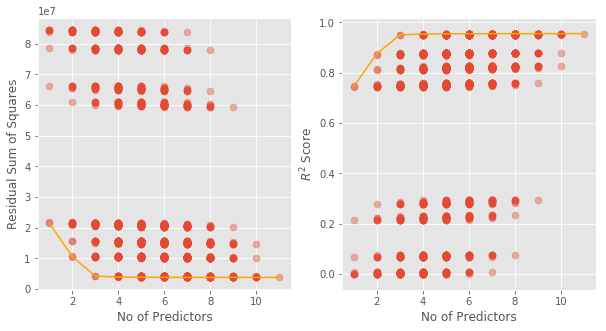

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5) )

# For each model plot the RSS score against the model size
ax1.scatter(x=subset_models['Model Size'], y=subset_models['RSS'], s = 50, alpha=0.4 )
# For each model size plot the lowest RSS score
ax1.plot(range(1,12),Mk_RSS[0], c = 'orange')
ax1.set_xlabel('No of Predictors')
ax1.set_ylabel('Residual Sum of Squares')

# For each model plot the R2 score against the model size
ax2.scatter(x=subset_models['Model Size'], y=subset_models['R2'], s = 50, alpha=0.4 )
# For each model size plot the lowest RSS score
ax2.plot(range(1,12),Mk_R2[0], c = 'orange')
ax2.set_xlabel('No of Predictors')
ax2.set_ylabel(r'$R^2$ Score')

In [50]:
### Identify row index for best subsets based on the RSS value
index_best_subset = pd.pivot_table(subset_models,columns='Model Size', values='R2' ,aggfunc=pd.Series.idxmax).values

###best_subsets[0].astype(int)
best_subset = subset_models.iloc[index_best_subset[0].astype(int)].copy()

After selecting the best model from each model size($M_0,...,M_p$), we can choose a single best using the cross validated prediction error, $C_p$, AIC, BIC or adjusted $R^2$.

As the number of predictors increase the model fit improves as well, however from three-variable model on, there is little improvement in the $RSS$ and $R^2$ as a result of including additional predictors. 
While the best subset selection in simple and conceptually simple, it has computational limitations. When considering a dataset with $p$ predictors there are $2^p$ possible model with needs to be evaluated to identify the best subset. Consequently, best subset selection becomes computationally infeasible for values of $p$ greater than around 20.

Additionally, larger the search space, there is a possibility that we will find models that are good on the training data, even though they might not be good at predicting on future data. A large search space can lead to overfitting and high variance of the coefficient estimates.

#### Forward Stepwise Selection
Forward stepwise selection begins with a model with no predictors and then adds predictors to the model one at a time, untill all the predictors are in the model. On each step the variable that gives the greatest additional improvement to the fit is added to the model.
**Forward stepwise selection**
1. Start with _null model_ $M_0$ which does not contain any predictors.
2. For $k=0,...,p-1$:  
    a. Consider all $p-k$ models that adds one additional predictor to the model $M_k$  
    b. Choose the best among these $p-k$ models using $RSS$ or $R^2$, and choose this model as $M_{k+1}$  
3. Select the single best model among $M_0,...,M_p$, using cross validated prediction error, $C_p (AIC), BIC$, or adjusted $R^2$

In [16]:
features = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender', 'd_Student', 'd_Married', 'D_African American', 'D_Asian']
target = 'Balance'

In [17]:
## Forward Selection

def forward_selection(df, features, target):
    models = []
    predictors = []
    null_RSS = sum((df[target] -df[target].mean())**2)
    base_RSS = null_RSS

    for i in range(len(features)):
        remaing = [feature for feature in features if feature not in predictors]
        for feature in remaing:
            X = df[predictors+[feature]]
            y = df['Balance']
            model = sm.OLS(y,sm.add_constant(X)).fit()
            RSS = (model.resid**2).sum()
            
            models.append({'Model Size':X.shape[1],'Model':model, 'Features':predictors+[feature], 'RSS':RSS})
            
            if RSS < base_RSS:
                base_RSS = RSS
                best_feature = feature
        predictors.append(best_feature)
        
    return pd.DataFrame(models)

In [18]:
forward_selection_models = forward_selection(credit, features, target)

In [19]:
Mk_RSS = pd.pivot_table(forward_selection_models,columns='Model Size', values='RSS' ,aggfunc=min).values

index_fselection = pd.pivot_table(forward_selection_models, columns='Model Size', values= 'RSS', aggfunc=pd.Series.idxmin).values
forward_selection_models.iloc[index_fselection[0].astype(int)]

,Features,Model,Model Size,RSS
2,[Rating],<statsmodels.regression.linear_model.Regressio...,1,2.143512e+07
11,"[Rating, Income]",<statsmodels.regression.linear_model.Regressio...,2,1.053254e+07
26,"[Rating, Income, d_Student]",<statsmodels.regression.linear_model.Regressio...,3,4.227219e+06
30,"[Rating, Income, d_Student, Limit]",<statsmodels.regression.linear_model.Regressio...,4,4.032502e+06
38,"[Rating, Income, d_Student, Limit, Cards]",<statsmodels.regression.linear_model.Regressio...,5,3.866091e+06
45,"[Rating, Income, d_Student, Limit, Cards, Age]",<statsmodels.regression.linear_model.Regressio...,6,3.821620e+06
52,"[Rating, Income, d_Student, Limit, Cards, Age,...",<statsmodels.regression.linear_model.Regressio...,7,3.810759e+06
58,"[Rating, Income, d_Student, Limit, Cards, Age,...",<statsmodels.regression.linear_model.Regressio...,8,3.800969e+06
61,"[Rating, Income, d_Student, Limit, Cards, Age,...",<statsmodels.regression.linear_model.Regressio...,9,3.794145e+06
63,"[Rating, Income, d_Student, Limit, Cards, Age,...",<statsmodels.regression.linear_model.Regressio...,10,3.789709e+06


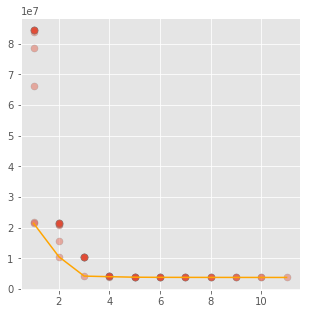

In [20]:
plt.figure(figsize=(5,5))
plt.scatter(forward_selection_models['Model Size'], forward_selection_models['RSS'], alpha = 0.4, s = 50, edgecolors='grey')
plt.plot(range(1,12),Mk_RSS[0], c = 'orange')

Forward step wise involves fitting one null model and $p-k$ models in each subsequent iteration. Which results in $1 + p(p+1)/2$ models, Whereas best subset selection involves fitting $2^p$ models. For a dataset with $p=20$ predictors best subset selection will fit $2^{20} = 1,048,576$ models whereas forward stepwise selection only requires fitting 211 models.

While forward stepwise selection is computationally efficient, it does not guarantee to find the best model out of $2^p$ models. Since at each iteration $M_k$ the model builds on the parameters selected in the previous iteration $M_{k-1}$, $M_k$ must also contain all the parameters used in $M_{k-1}$ regardless of whether all the parameters in $M_{k-1}$ are useful to the model.

In [21]:
def backward_selection(df, features, target):
    predictors = features[:]
    models = []
    for i in range(len(features),0,-1):
        base_RSS = np.Infinity
        for subset in combinations(predictors,i):
            X = df[list(subset)]
            y = df[target]

            model = sm.OLS(y,X).fit()
            RSS = sum(model.resid**2)

            if RSS <base_RSS:
                base_RSS = RSS
                predictors = subset

            models.append({'Model Size':i, 'Subset':subset, 'Model':model, 'RSS':RSS})
    
    return pd.DataFrame(models)

In [22]:
backward_selection_models = backward_selection(credit, features, target)
backward_selection_models.head()

,Model,Model Size,RSS,Subset
0,<statsmodels.regression.linear_model.Regressio...,11,5.619638e+06,"(Income, Limit, Rating, Cards, Age, Education,..."
1,<statsmodels.regression.linear_model.Regressio...,10,5.641156e+06,"(Income, Limit, Rating, Cards, Age, Education,..."
2,<statsmodels.regression.linear_model.Regressio...,10,5.648181e+06,"(Income, Limit, Rating, Cards, Age, Education,..."
3,<statsmodels.regression.linear_model.Regressio...,10,5.639400e+06,"(Income, Limit, Rating, Cards, Age, Education,..."
4,<statsmodels.regression.linear_model.Regressio...,10,1.217785e+07,"(Income, Limit, Rating, Cards, Age, Education,..."


In [23]:
Mk_RSS = pd.pivot_table(backward_selection_models,columns='Model Size', values='RSS' ,aggfunc=min).values

index_bwselection = pd.pivot_table(backward_selection_models, columns='Model Size', values= 'RSS', aggfunc=pd.Series.idxmin).values
backward_selection_models.iloc[index_bwselection[0].astype(int)]

,Model,Model Size,RSS,Subset
65,<statsmodels.regression.linear_model.Regressio...,1,2.828499e+07,"(Limit,)"
61,<statsmodels.regression.linear_model.Regressio...,2,2.159338e+07,"(Income, Limit)"
57,<statsmodels.regression.linear_model.Regressio...,3,1.346988e+07,"(Income, Limit, Education)"
54,<statsmodels.regression.linear_model.Regressio...,4,6.993371e+06,"(Income, Limit, Education, d_Student)"
49,<statsmodels.regression.linear_model.Regressio...,5,5.936228e+06,"(Income, Limit, Age, Education, d_Student)"
42,<statsmodels.regression.linear_model.Regressio...,6,5.895924e+06,"(Income, Limit, Rating, Age, Education, d_Stud..."
32,<statsmodels.regression.linear_model.Regressio...,7,5.778031e+06,"(Income, Limit, Rating, Cards, Age, Education,..."
22,<statsmodels.regression.linear_model.Regressio...,8,5.680000e+06,"(Income, Limit, Rating, Cards, Age, Education,..."
12,<statsmodels.regression.linear_model.Regressio...,9,5.659271e+06,"(Income, Limit, Rating, Cards, Age, Education,..."
3,<statsmodels.regression.linear_model.Regressio...,10,5.639400e+06,"(Income, Limit, Rating, Cards, Age, Education,..."


Text(0,0.5,'RSS')

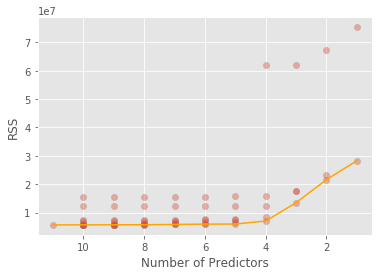

In [24]:
plt.scatter(backward_selection_models['Model Size'], backward_selection_models['RSS'], alpha = 0.4, s =40, edgecolors='grey')
plt.plot(range(1,12,1), Mk_RSS[0], c = 'orange')
plt.gca().invert_xaxis()
plt.xlabel('Number of Predictors')
plt.ylabel('RSS')

In [51]:
best_subset['BIC'] = best_subset.apply(lambda row: row[0].bic,axis=1)
best_subset['Adjusted R2'] = best_subset.apply(lambda row: row[0].rsquared_adj,axis=1)

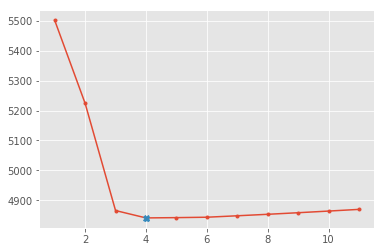

In [52]:
plt.plot(best_subset['Model Size'], best_subset['BIC'],marker = '.')
plt.plot(best_subset['Model Size'].loc[best_subset['BIC'].idxmin()],best_subset['BIC'].min(), marker = 'X')

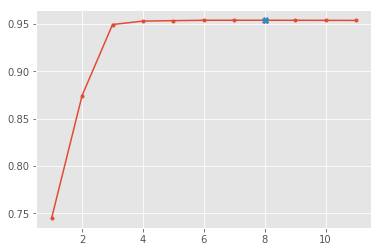

In [53]:
plt.plot(best_subset['Model Size'], best_subset['Adjusted R2'], marker = '.')
plt.plot(best_subset['Model Size'].loc[best_subset['Adjusted R2'].idxmax()],best_subset['Adjusted R2'].max(), marker = 'X')

In [159]:
validation_set_error = []
for subset in best_subset['Subset']:
    X_train, X_test, y_train, y_test = train_test_split(credit[list(subset)], credit['Balance'],test_size=0.25)

    regr = LinearRegression()

    model = regr.fit(X_train, y_train)

    validation_set_error.append(mean_squared_error(y_test, model.predict(X_test)))

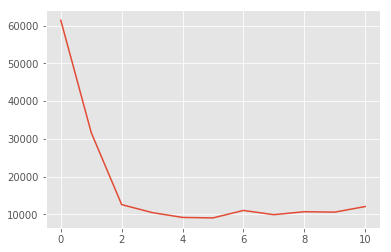

In [160]:
plt.plot(neg_mean_squared_error)
plt.plot()

In [166]:
crossValidationSetError = []
for subset in best_subset['Subset']:
    regr = LinearRegression()

    cv_error = cross_val_score(regr,credit[list(subset)], credit['Balance'],scoring= 'neg_mean_squared_error').mean()

    crossValidationSetError.append(-cv_error)

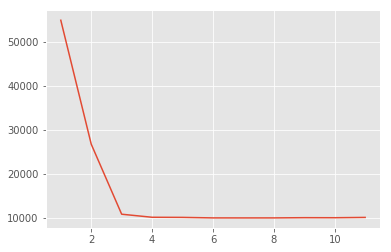

In [169]:
plt.plot(range(1,12),crossValidationSetError)

In [170]:
crossValidationSetError

[54857.99588040213,
 26702.257894747283,
 10788.414936663352,
 10094.036352064632,
 10068.79328664381,
 9950.287364486614,
 9947.167790764812,
 9950.693450058028,
 10002.679303484669,
 9990.167453242024,
 10062.052549775306]

In [203]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import StandardScaler

In [172]:
StandardScaler.fit_transform()
credit[['Income', 'Limit', 'Rating', 'd_Student']]

In [202]:
for alpha in (0.001, 0.01, 0.1, 1, 10, 100):
    regr_ridge = Ridge(alpha= alpha)
    X = credit[['Income', 'Limit', 'Rating', 'd_Student']]
    y = credit['Balance']
    regr_ridge.fit(X,y)
    print ('Coefficients:\n\tIncome:{0}\n\tLimit:{1}\n\tRating:{2}\n\tStudent;{3}'.format(regr_ridge.coef_[0],regr_ridge.coef_[1],regr_ridge.coef_[2],regr_ridge.coef_[3]))

Coefficients:
	Income:-7.944627571471388
	Limit:0.12168145735129379
	Rating:2.19045285914015
	Student;422.65659079760627
Coefficients:
	Income:-7.944570635356614
	Limit:0.12167218883479163
	Rating:2.1905800136566835
	Student;422.5505293525289
Coefficients:
	Income:-7.944002831297336
	Limit:0.1215797595376084
	Rating:2.191848045828837
	Student;421.4928352239231
Coefficients:
	Income:-7.938476278905335
	Limit:0.1206803597927008
	Rating:2.2041865905741083
	Student;411.20001031056563
Coefficients:
	Income:-7.895059264076741
	Limit:0.11363336118687804
	Rating:2.3008402958338405
	Student;330.49365064579825
Coefficients:
	Income:-7.774471454286431
	Limit:0.09469198825486809
	Rating:2.55990481288904
	Student;111.55095863177768


In [194]:
regr_ridge.coef_[3]

422.65659079760627